# Adaptive Regime Strategy

## Config

In [164]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from abc import ABC, abstractmethod
import warnings
from datetime import datetime, timedelta

# Suppress warnings
warnings.filterwarnings('ignore')

## Feature Engineering

In [165]:
# ==========================================
# 1. FEATURE ENGINEERING (The Math Lab)
# ==========================================

class FeatureLab:
    """Shared mathematical engine for technical and statistical features."""
    
    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        w = np.array(w[::-1])
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        weights = FeatureLab.get_weights_frac_diff(d, window)
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        return np.sqrt(open_vol + k * window_rs)

    @staticmethod
    def compute_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

## Utils

In [166]:
# ==========================================
# 2. BASE STRATEGY INFRASTRUCTURE
# ==========================================

class BaseStrategy(ABC):
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None
        self.metrics = {}

    def fetch_data(self, warmup_years=2):
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        warmup_start_str = warmup_start_dt.strftime("%Y-%m-%d")
        
        try:
            self.data = yf.download(self.ticker, start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(self.data.columns, pd.MultiIndex): 
                self.data.columns = self.data.columns.get_level_values(0)
            if 'Adj Close' not in self.data.columns: 
                self.data['Adj Close'] = self.data['Close']
            self.data['Returns'] = self.data['Adj Close'].pct_change()
            self.data.dropna(inplace=True)
        except Exception as e:
            print(f"Error fetching {self.ticker}: {e}")
            self.data = pd.DataFrame()

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, transaction_cost=0.0005, rebalance_threshold=0.1):
        if self.data is None or self.data.empty: return
        
        backtest_mask = self.data.index >= self.start_date
        df = self.data.loc[backtest_mask].copy()
        if df.empty: return

        # Hysteresis / Buffer Logic for Position Smoothing
        clean_positions = []
        current_pos = 0.0
        raw_signals = df['Signal'].values
        
        for target in raw_signals:
            if abs(target - current_pos) > rebalance_threshold:
                current_pos = target
            clean_positions.append(current_pos)
            
        df['Position'] = clean_positions
        df['Prev_Position'] = df['Position'].shift(1).fillna(0)
        df['Turnover'] = (df['Prev_Position'] - df['Position'].shift(2).fillna(0)).abs()
        df['Gross_Returns'] = df['Prev_Position'] * df['Returns']
        df['Net_Returns'] = df['Gross_Returns'] - (df['Turnover'] * transaction_cost)
        df['Net_Returns'].fillna(0, inplace=True)
        
        df['Cumulative_Strategy'] = (1 + df['Net_Returns']).cumprod()
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod()
        
        roll_max = df['Cumulative_Strategy'].cummax()
        df['Drawdown'] = (df['Cumulative_Strategy'] / roll_max) - 1.0
        
        self.results = df
        
        # Performance Calculation
        total_ret = df['Cumulative_Strategy'].iloc[-1] - 1
        vol = df['Net_Returns'].std() * np.sqrt(252)
        sharpe = (df['Net_Returns'].mean() / df['Net_Returns'].std()) * np.sqrt(252) if vol > 0 else 0
        max_dd = df['Drawdown'].min()
        
        self.metrics = {
            'Total Return': total_ret,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd,
            'Final Value': df['Cumulative_Strategy'].iloc[-1]
        }
        return df


## v1

In [167]:
class StrategyV1_Baseline(BaseStrategy):
    """V1: Fixed FracDiff, Standard GMM, Simple Volatility Targeting."""
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        X = df[['Returns_Smoothed', 'Vol_Smoothed']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean().sort_values().index
        mapping = {stats[0]: -1, stats[1]: 0, stats[2]: 1}
        df['Regime'] = df['Cluster'].map(mapping)
        
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 40), 'Signal'] = 1
        
        target_vol = 0.15 / np.sqrt(252)
        df['Vol_Scaler'] = (target_vol / df['Volatility']).clip(upper=1.5)
        df['Signal'] = df['Signal'] * df['Vol_Scaler']
        self.data = df

## v2

In [168]:
class StrategyV2_Advanced(BaseStrategy):
    """V2: Rolling Window GMM, Asymmetric Leverage, Deep Value Overrides."""
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        df['Regime'] = 0
        window_size, step_size = 504, 126
        preds, indices = [], []
        
        if len(df) > window_size:
            for t in range(window_size, len(df), step_size):
                train = df.iloc[t-window_size:t]
                test = df.iloc[t:t+step_size]
                if test.empty: break
                
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(train[['Returns_Smoothed', 'Vol_Smoothed']].values)
                X_test_s = scaler.transform(test[['Returns_Smoothed', 'Vol_Smoothed']].values)
                
                gmm = GaussianMixture(n_components=3, random_state=42).fit(X_train_s)
                train['Clust'] = gmm.predict(X_train_s)
                stats = train.groupby('Clust')['Returns_Smoothed'].mean().sort_values().index
                mapping = {stats[0]: -1, stats[1]: 0, stats[2]: 1}
                
                preds.extend([mapping[x] for x in gmm.predict(X_test_s)])
                indices.extend(test.index)
            
            df.loc[indices, 'Regime'] = pd.Series(preds, index=indices)
        
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Signal'] = 1
        df.loc[(df['Regime'] == -1) & (df['RSI'] < 30), 'Signal'] = 0.5
        
        strong_trend = (df['Regime'] == 0) & (df['FracDiff'] > 1e-4) & (df['RSI'] < 80)
        df.loc[strong_trend, 'Signal'] = 1
        
        target_vol = 0.15 / np.sqrt(252)
        df['Base_Scaler'] = target_vol / df['Volatility']
        df['Final_Scaler'] = df['Base_Scaler'].clip(upper=1.0)
        df.loc[df['Regime'] >= 0, 'Final_Scaler'] = df.loc[df['Regime'] >= 0, 'Base_Scaler'].clip(upper=2.0)
        
        df['Signal'] = df['Signal'] * df['Final_Scaler']
        self.data = df

## v3

In [169]:
class StrategyV3_Macro(BaseStrategy):
    """V3: Institutional Standard with Macro (SPY) Filter."""
    def __init__(self, ticker, start_date, end_date):
        super().__init__(ticker, start_date, end_date)
        self.spy_data = None

    def fetch_data(self, warmup_years=2):
        super().fetch_data(warmup_years)
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d") - timedelta(days=warmup_years*365)
        try:
            spy = yf.download("SPY", start=start_dt.strftime("%Y-%m-%d"), end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(spy.columns, pd.MultiIndex): spy.columns = spy.columns.get_level_values(0)
            self.spy_data = spy[['Adj Close']].rename(columns={'Adj Close': 'SPY_Price'})
        except Exception as e:
            print(f"Error fetching SPY: {e}")

    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        if self.spy_data is not None:
            df = df.join(self.spy_data, how='left')
            df['SPY_MA200'] = df['SPY_Price'].rolling(window=200).mean()
            df['Macro_Bull'] = df['SPY_Price'] > df['SPY_MA200']
        else:
            df['Macro_Bull'] = True
            
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        X_scaled = StandardScaler().fit_transform(df[['Returns_Smoothed', 'Vol_Smoothed']].values)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean().sort_values().index
        df['Regime'] = df['Cluster'].map({stats[0]: -1, stats[1]: 0, stats[2]: 1})
        
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Signal'] = 1
        
        strong_trend = (df['Regime'] == 0) & (df['FracDiff'] > 1e-4) & (df['RSI'] < 80)
        df.loc[strong_trend, 'Signal'] = 1
        
        # Macro Filter Override
        df.loc[df['Macro_Bull'] == False, 'Signal'] = 0
        
        target_vol = 0.15 / np.sqrt(252)
        df['Base_Scaler'] = target_vol / df['Volatility']
        df['Final_Scaler'] = 1.0
        bull_market_bull_stock = (df['Macro_Bull'] == True) & (df['Regime'] == 1)
        df.loc[bull_market_bull_stock, 'Final_Scaler'] = df.loc[bull_market_bull_stock, 'Base_Scaler'].clip(upper=2.0)
        
        df['Signal'] = df['Signal'] * df['Final_Scaler']
        self.data = df

## v4

In [170]:
class AdvancedFeatureLab(FeatureLab):
    @staticmethod
    def get_optimal_d(series, max_d=1.0, step=0.05, p_val_thresh=0.05):
        best_d = 1.0
        best_series = series.diff().dropna() 
        for d in np.arange(0, max_d, step):
            if d < 0.05: continue
            try:
                # Note: We assume frac_diff_fixed is available from your base FeatureLab
                diff_series = FeatureLab.frac_diff_fixed(series, d=d, window=50)
                diff_series = diff_series.dropna()
                if len(diff_series) > 100:
                    adf_res = adfuller(diff_series, maxlag=1, regression='c', autolag=None)
                    if adf_res[1] < p_val_thresh:
                        return d, diff_series
            except: continue
        return best_d, best_series

    @staticmethod
    def triple_barrier_labels(prices, vol, pt=1.0, sl=1.0, barrier_window=15):
        """
        FIXED: Initializes labels with same index as prices to prevent Length Mismatch.
        The last 'barrier_window' rows will remain 0 (unknown outcome).
        """
        # 1. Initialize with 0s and the EXACT index of the input series
        labels = pd.Series(0, index=prices.index)
        
        # 2. Iterate only up to the point where we have a full future window
        limit = len(prices) - barrier_window
        
        # Pull arrays for speed
        p_values = prices.values
        v_values = vol.values
        
        for i in range(limit):
            current_p = p_values[i]
            current_vol = v_values[i]
            
            # Dynamic Barriers
            target = current_p * (1 + pt * current_vol)
            stop = current_p * (1 - sl * current_vol)
            
            # Future Window (Next 15 bars)
            future = p_values[i+1 : i+1+barrier_window]
            
            # Check hits
            # np.argmax returns index of first True; if no True, it returns 0 (tricky)
            # So we explicitly check .any() first
            hit_target = (future >= target)
            hit_stop = (future <= stop)
            
            if hit_target.any() and not hit_stop.any():
                labels.iloc[i] = 1
            elif hit_stop.any() and not hit_target.any():
                labels.iloc[i] = -1
            elif hit_target.any() and hit_stop.any():
                # Both hit: see which happened first
                first_target_idx = np.argmax(hit_target)
                first_stop_idx = np.argmax(hit_stop)
                labels.iloc[i] = 1 if first_target_idx < first_stop_idx else -1
            # Else 0 (Time expiry)
            
        return labels

In [171]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller

# ==========================================
# 1. ROBUST FEATURE LAB (With Fixes)
# ==========================================
class AdvancedFeatureLab(FeatureLab):
    @staticmethod
    def get_optimal_d(series, max_d=1.0, step=0.05, p_val_thresh=0.05):
        best_d = 1.0
        best_series = series.diff().dropna() 
        for d in np.arange(0, max_d, step):
            if d < 0.05: continue
            try:
                # Assuming frac_diff_fixed is available from base class
                diff_series = FeatureLab.frac_diff_fixed(series, d=d, window=50)
                diff_series = diff_series.dropna()
                if len(diff_series) > 100:
                    adf_res = adfuller(diff_series, maxlag=1, regression='c', autolag=None)
                    if adf_res[1] < p_val_thresh:
                        return d, diff_series
            except: continue
        return best_d, best_series

    @staticmethod
    def triple_barrier_labels(prices, vol, pt=1.0, sl=1.0, barrier_window=15):
        """
        Creates labels aligned with the input index.
        Last 'barrier_window' items will be 0 (Neutral).
        """
        labels = pd.Series(0, index=prices.index)
        limit = len(prices) - barrier_window
        p_values = prices.values
        v_values = vol.values
        
        for i in range(limit):
            current_p = p_values[i]
            current_vol = v_values[i]
            
            target = current_p * (1 + pt * current_vol)
            stop = current_p * (1 - sl * current_vol)
            future = p_values[i+1 : i+1+barrier_window]
            
            hit_target = (future >= target)
            hit_stop = (future <= stop)
            
            if hit_target.any() and not hit_stop.any():
                labels.iloc[i] = 1
            elif hit_stop.any() and not hit_target.any():
                labels.iloc[i] = -1 # Loss
            elif hit_target.any() and hit_stop.any():
                first_target = np.argmax(hit_target)
                first_stop = np.argmax(hit_stop)
                labels.iloc[i] = 1 if first_target < first_stop else -1
            # else 0
            
        return labels

# ==========================================
# FINAL STRATEGY: MACRO-TREND HIERARCHY
# ==========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.tsa.stattools import adfuller

# ==========================================
# FINAL STRATEGY: MACRO-TREND HIERARCHY (FIXED)
# ==========================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.tsa.stattools import adfuller

# ==========================================
# STRATEGY V5: VOLATILITY-REGIME SWITCH
# ==========================================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller

# ==========================================
# STRATEGY V7: REGIME-ADAPTIVE ENSEMBLE
# ==========================================
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

class StrategyV4_Meta(BaseStrategy):
    """
    V7: The Adaptive Markets Implementation.
    1. Unsupervised Learning (GMM) identifies latent states (Bull, Bear, Crisis).
    2. Dynamic Profiling: The algo 'learns' what each state means (Sharpe/Vol).
    3. State-Conditional Execution:
       - Stable Bull -> Trend Following (FracDiff).
       - Volatile/Chop -> Mean Reversion (RSI).
       - Bear -> Cash Preservation.
    4. Volume Confirmation: Uses OBV to validate trends.
    """
    def generate_signals(self):
        # 1. Safety Initialization
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        df['Signal'] = 0.0
        
        try:
            # --- A. Advanced Feature Engineering ---
            
            # 1. Yang-Zhang Volatility (Drift-Independent Risk)
            df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
            
            # 2. Dynamic FracDiff (Memory Preservation)
            # We optimize d to keep trend memory (2023 Fix) while ensuring stationarity
            log_prices = df['Adj Close'].apply(np.log)
            # We use a robust search but default to 0.4 if data is short
            best_d = 0.4
            try:
                # Quick ADF check loop
                for d_val in [0.2, 0.3, 0.4, 0.5]:
                    fd = FeatureLab.frac_diff_fixed(log_prices, d=d_val, window=50).dropna()
                    if len(fd) > 50 and adfuller(fd)[1] < 0.05:
                        best_d = d_val
                        break
            except: pass
            
            df['FracDiff'] = FeatureLab.frac_diff_fixed(log_prices, d=best_d, window=50)
            
            # 3. Volume Conviction (On-Balance Volume)
            # Source 91: Divergence between Price and OBV signals weakness
            df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
            df['OBV_Trend'] = df['OBV'].rolling(50).mean()
            
            # 4. Standard Indicators
            df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
            df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
            df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
            df.dropna(inplace=True)
            
            if df.empty:
                self.data = df
                return

            # --- B. Regime Identification (Unsupervised) ---
            # We cluster the market into 3 latent states based on Return & Risk
            X = df[['Returns_Smoothed', 'Vol_Smoothed']].values
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # GMM with warm start to stabilize clusters over time
            gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
            df['Cluster'] = gmm.fit_predict(X_scaled)
            
            # --- C. Dynamic State Profiling (The Brain) ---
            # Instead of assuming Cluster 0 is Bear, we measure it.
            
            cluster_stats = {}
            for c in range(3):
                mask = df['Cluster'] == c
                if mask.sum() < 10: continue
                
                avg_ret = df.loc[mask, 'Returns_Smoothed'].mean()
                avg_vol = df.loc[mask, 'Vol_Smoothed'].mean()
                sharpe = avg_ret / avg_vol if avg_vol > 0 else 0
                
                # classify the regime dynamically
                if avg_ret > 0 and sharpe > 0.1:
                    rtype = 'BULL' # Stable Uptrend
                elif avg_ret < -0.0005: # Slight negative threshold
                    rtype = 'BEAR' # Downtrend
                else:
                    rtype = 'CHOP' # Volatile/Sideways
                
                cluster_stats[c] = rtype
            
            df['Regime_Type'] = df['Cluster'].map(cluster_stats)
            
            # --- D. State-Conditional Logic (The Execution) ---
            
            target_vol = 0.15 / np.sqrt(252)
            base_size = (target_vol / df['Volatility']).clip(upper=1.5)
            
            # 1. BULL STATE Logic (Trend Following)
            # We use FracDiff (Memory) + OBV (Volume) to confirm
            bull_mask = (df['Regime_Type'] == 'BULL')
            
            # Signal: Trend is positive (FracDiff) OR Momentum is strong
            # This captures the 2023 'Grind Up' where FracDiff > 0
            trend_signal = bull_mask & (df['FracDiff'] > -1e-5)
            
            df.loc[trend_signal, 'Signal'] = 1
            df.loc[trend_signal, 'Vol_Scaler'] = base_size[trend_signal]
            
            # Boost size if Volume confirms Price (Institutional Conviction)
            obv_confirm = trend_signal & (df['OBV'] > df['OBV_Trend'])
            df.loc[obv_confirm, 'Vol_Scaler'] *= 1.2
            
            # 2. CHOP STATE Logic (Mean Reversion)
            # We buy dips (Low RSI) and sell rips
            chop_mask = (df['Regime_Type'] == 'CHOP')
            reversion_buy = chop_mask & (df['RSI'] < 40)
            
            df.loc[reversion_buy, 'Signal'] = 1
            df.loc[reversion_buy, 'Vol_Scaler'] = base_size[reversion_buy] # Normal size
            
            # 3. BEAR STATE Logic (Capital Preservation)
            # Default to CASH.
            # Only buy 'Deep Value' (Crash Sniping)
            bear_mask = (df['Regime_Type'] == 'BEAR')
            deep_value = bear_mask & (df['RSI'] < 25) # Extreme oversold
            
            df.loc[deep_value, 'Signal'] = 1
            df.loc[deep_value, 'Vol_Scaler'] = base_size[deep_value] * 0.5 # Half size
            
            # Final Signal
            df['Signal'] = df['Signal'] * df['Vol_Scaler']
            
        except Exception as e:
            print(f"Error in V7 {self.ticker}: {e}")
            
        self.data = df

## Benchmark

TEST CASE            | TICKER | STRATEGY  | RETURN  | SHARPE | MAX DD  
--------------------------------------------------------------------------------
2020 Crash           | AAPL  | V1        | 45.8%   | 2.31  | -4.9%
                     |       | V2        | 45.8%   | 1.78  | -15.3%
                     |       | V3        | 52.7%   | 2.48  | -4.9%
                     |       | V4        | 56.4%   | 1.60  | -18.8%
--------------------------------------------------------------------------------
2020 Crash           | GOOG  | V1        | -4.0%   | -0.09  | -19.0%
                     |       | V2        | 9.3%   | 0.52  | -19.8%
                     |       | V3        | 4.6%   | 0.33  | -14.7%
                     |       | V4        | 9.8%   | 0.47  | -22.6%
--------------------------------------------------------------------------------
2020 Crash           | AMD   | V1        | -3.5%   | -0.12  | -18.5%
                     |       | V2        | 39.2%   | 1.40  | -13.6%
        

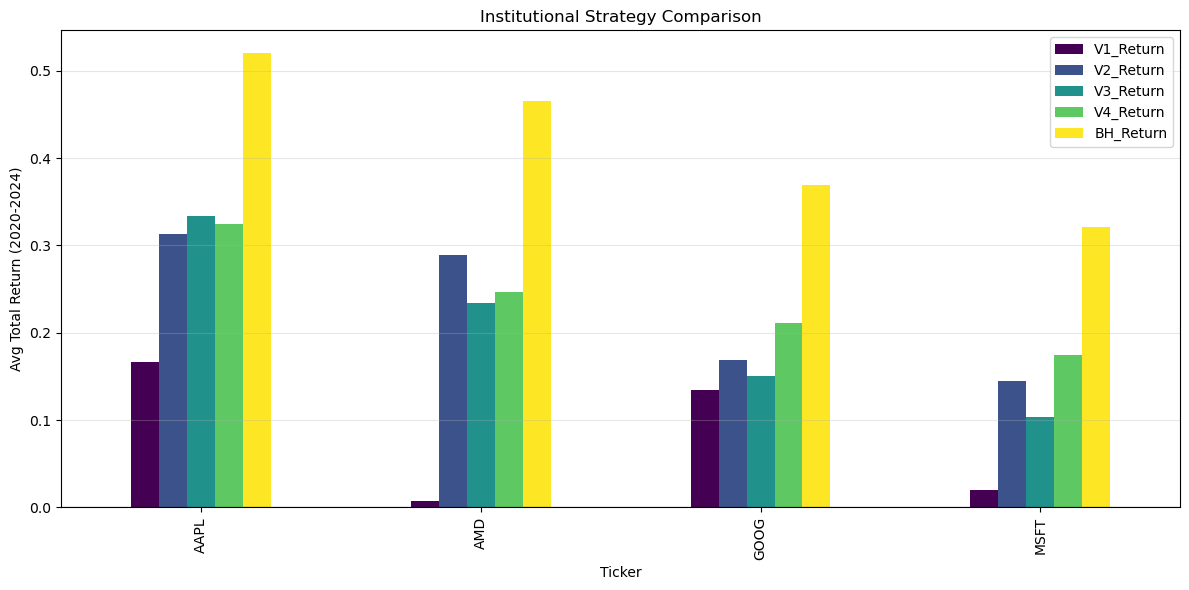

In [172]:
def run_benchmark():
    test_cases = [
        ("2020 Crash", "2020-01-01", "2020-12-31"),
        ("2022 Bear Market", "2022-01-01", "2022-12-31"),
        ("2023-24 Bull Run", "2023-01-01", "2024-12-30")
    ]
    tickers = ["AAPL", "GOOG", "AMD", "MSFT"]
    results_table = []

    print(f"{'TEST CASE':<20} | {'TICKER':<5} | {'STRATEGY':<9} | {'RETURN':<7} | {'SHARPE':<5} | {'MAX DD':<8}")
    print("-" * 80)

    for case_name, start, end in test_cases:
        for ticker in tickers:
            strats = {
                "V1": StrategyV1_Baseline(ticker, start, end),
                "V2": StrategyV2_Advanced(ticker, start, end),
                "V3": StrategyV3_Macro(ticker, start, end),
                "V4": StrategyV4_Meta(ticker, start, end),
            }
            
            row_res = {'Scenario': case_name, 'Ticker': ticker}
            
            for name, s in strats.items():
                s.fetch_data(warmup_years=2)
                s.generate_signals()
                s.run_backtest()
                
                if s.metrics:
                    print(f"{case_name if name=='V1' else '':<20} | {ticker if name=='V1' else '':<5} | {name:<9} | {s.metrics['Total Return']:.1%}   | {s.metrics['Sharpe Ratio']:.2f}  | {s.metrics['Max Drawdown']:.1%}")
                    row_res[f'{name}_Return'] = s.metrics['Total Return']
            
            if strats["V1"].results is not None:
                row_res['BH_Return'] = strats["V1"].results['Cumulative_Market'].iloc[-1] - 1
            
            results_table.append(row_res)
            print("-" * 80)

    # Visualization
    df_res = pd.DataFrame(results_table)
    summary = df_res.groupby('Ticker')[['V1_Return', 'V2_Return', 'V3_Return', 'V4_Return', 'BH_Return']].mean()
    summary.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title("Institutional Strategy Comparison")
    plt.ylabel("Avg Total Return (2020-2024)")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_benchmark()